# Explore here

It's recommended to use this notebook for exploration purposes.

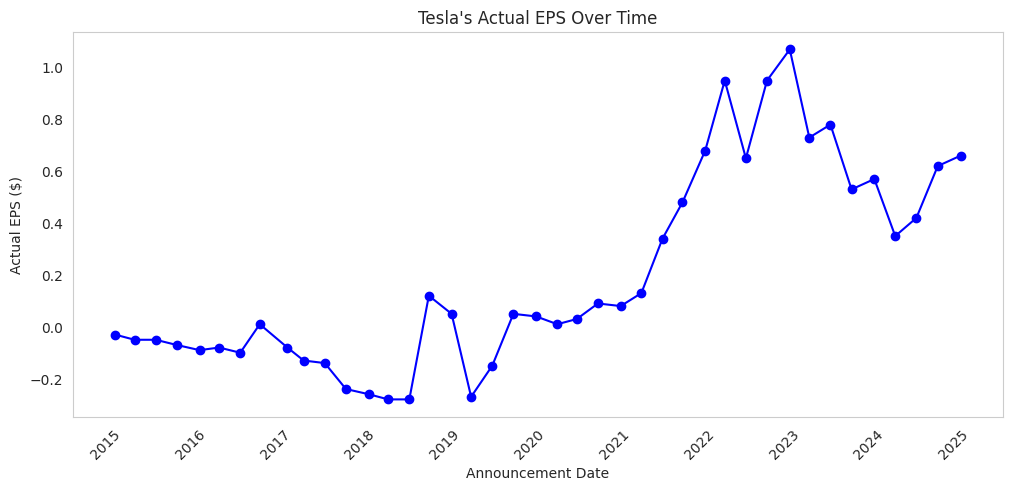

In [4]:
import os
import requests
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup

url = 'https://www.alphaquery.com/stock/TSLA/earnings-history'

res = requests.get(url)
scraped_html = BeautifulSoup(res.text, 'html.parser')

table = scraped_html.find('table')

if table:
    header_row = table.find_all('th')
    headers = [th.text.strip() for th in header_row]


    earnings_df = pd.DataFrame(columns=headers)
    rows = table.find_all('tr')

    for row in rows[1:]: 
        cells = row.find_all('td')
        data = [cell.text.strip() for cell in cells]
        earnings_df.loc[len(earnings_df)] = data

    earnings_df.columns = earnings_df.columns.str.strip()
    earnings_df['Estimated EPS'] = earnings_df['Estimated EPS'].str.replace(r'[$,]', '', regex=True)
    earnings_df['Actual EPS'] = earnings_df['Actual EPS'].str.replace(r'[$,]', '', regex=True)
    earnings_df['Estimated EPS'] = pd.to_numeric(earnings_df['Estimated EPS'], errors='coerce')
    earnings_df['Actual EPS'] = pd.to_numeric(earnings_df['Actual EPS'], errors='coerce')
    earnings_df['Announcement Date'] = pd.to_datetime(earnings_df['Announcement Date'], errors='coerce')

    conn = sqlite3.connect('earnings.db')
    earnings_df.to_sql("tesla_earnings", conn, if_exists='replace', index=False)
    conn.close()

    sns.set_style("whitegrid")

    plt.figure(figsize=(12, 5))
    plt.plot(earnings_df['Announcement Date'], earnings_df['Actual EPS'], marker='o', linestyle='-', color='b')
    plt.title("Tesla's Actual EPS Over Time")
    plt.xlabel("Announcement Date")
    plt.ylabel("Actual EPS ($)")
    plt.xticks(rotation=45)
    plt.grid()
    plt.show()

else:
    print("Error: Earnings data table not found on the page.")
